## Final Project Submission


* Student name: Robert Fustero 
* Student pace: part time
* Scheduled project review 6/7/19
* Instructor name: Brandon Lewis

In [1]:
# import necessary libraries
import sqlite3
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
from scipy import stats
import itertools
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# Introduction
In this project I will be doing statistical analysis on *NorthWind*, a fictious company made my Microsoft for training purposes. <br>
I will also being showcasing some SQL knowldge inorder to speed up the processing time. <br>

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)


In [3]:
#Importing necessart items from the database I will be looking at
#these include: CategoryId (type of product), Profit made per purchase,
#Shipping Region, Discounts, etc
query = '''SELECT  Product.CategoryId,
                            ((Product.UnitPrice -OrderDetail.UnitPrice) * OrderDetail.Quantity) As Revenue,
                            OrderDetail.Discount,
                            'Order'.ShipRegion, 
                            'Order'.OrderDate,
                            OrderDetail.Quantity,
                            Customer.Id,
                            'Order'.Id as OrderId
                            FROM Product, 'Order'
                            JOIN OrderDetail on 'Order'.id = OrderDetail.OrderID
                            JOIN Customer on 'Order'.CustomerId = Customer.Id '''
                            
df = pd.read_sql_query(query, conn)
df['Month'] = pd.DatetimeIndex(df['OrderDate']).month_name()

# Cohen's D

### *Statistical significance is not everything*

It’s important to have some measure of how practically significant two populations are, and this is done by calculating effect size.

Cohen’s d is one of the most common ways we measure the size of an effect.

Welch's pooled variance T test measures the difference between the averages of two groups by subtracting their means and dividing it by the pooled standard deviation.  This is effective for seeing the difference between two populations of different sample size.

In this project, you can tell the difference by the two groups by color - light green being the experiment and grey being the control

# ANOVA
### *Analysis of Variance*
ANOVA is a statistical method used to test differences between two or more means.
I will be using this statistical procedure to analyze the difference between groups larger than two. For example - different months <br>
$F$ > $P(F)$ Is a sign there could be something worth looking at, but unless the p value is lower than .05 it's not statistically significant.

In [4]:
### Helper Function to measure Cohen's D
def Cohen_d(group1, group2):
    #groups are numpy arrays or pandas series
    
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate pooped variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [5]:
### Helper Function to measure Cohen's D
def Cohen_dmed(group1, group2):
    #groups are numpy arrays or pandas series
    
    diff = group1.median() - group2.median()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    # Calculate pooped variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [6]:
### Helper Function to make visual faster
def visualization(control, experimental,colors):
    plt.figure(figsize=(10,6))
    sns.distplot(experimental, bins=50,  label='Experimental',color=colors[0])
    sns.distplot(control, bins=50,  label='Control',color=colors[1])

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')

    plt.title('Control and Experimental Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

In [7]:
### Helper Function to make visual faster
#includes plt.margins to zoom in on graph
def smallvisualization(control, experimental,colors):
    plt.figure(figsize=(15,5))
    sns.distplot(experimental, bins=50,  label='Experimental',color=colors[0])
    sns.distplot(control, bins=50,  label='Control',color=colors[1])

    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')
    plt.margins(-.25,-.1)
    plt.title('Control and Experimental Sampling Distributions', fontsize=14)
    plt.xlabel('Distributions')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Question 1(A): 
## Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

*$H_{0}$* : There is no significant difference in amount ordered due to discounts <br>
*$H_{a}$* : TThere is a significant difference in amount ordered due to discounts

In [10]:

discount = pd.read_sql_query("""SELECT * FROM 'order'
                JOIN orderdetail ON 'order'.id = OrderId WHERE Discount > 0 """, conn).groupby('ProductId')['Quantity'].mean()
nodiscount = pd.read_sql_query("""SELECT * FROM 'order'
                JOIN orderdetail ON 'order'.id = OrderId WHERE Discount = 0 """, conn).groupby('ProductId')['Quantity'].mean()

print(stats.kstest(discount, 'norm', args=(discount.mean(),discount.std())))
print(stats.kstest(nodiscount, 'norm', args=(nodiscount.mean(),nodiscount.std())))

KstestResult(statistic=0.0735122761758139, pvalue=0.7996096123654964)
KstestResult(statistic=0.09649019893878974, pvalue=0.447586559857033)


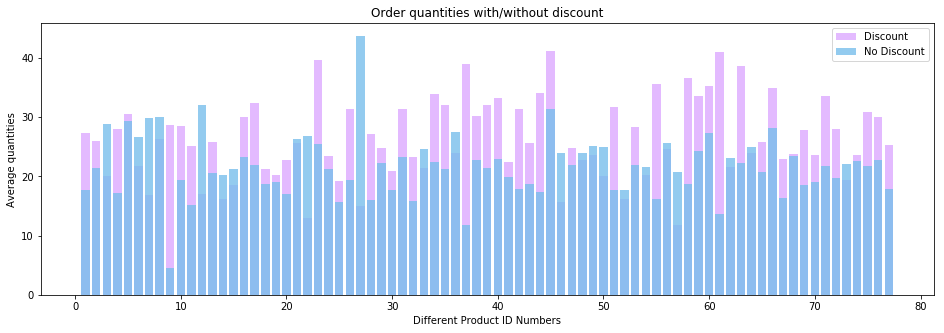

In [8]:

plt.figure(figsize=(16,5))
plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#E3BAFF')
plt.bar(nodiscount.index, nodiscount.values, alpha=0.8, label='No Discount', color='#78BEEB')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Different Product ID Numbers')
plt.ylabel('Average quantities')
plt.show()



###### So we can see there is a difference between order quantity with/without discounts - but is that difference significant?

Reject Null Hypothesis
Cohen's d: 0.2862724481729283


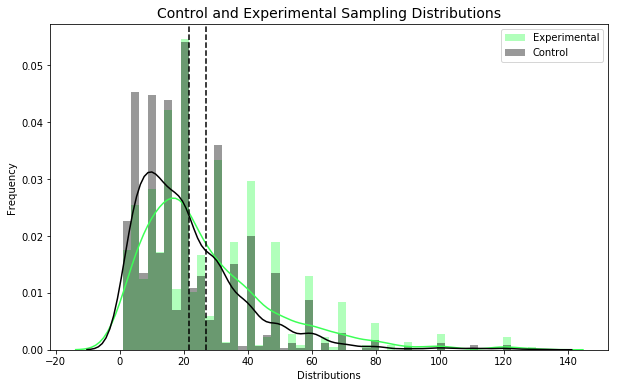

In [18]:
control = pd.read_sql_query("""SELECT * FROM 'order'
                JOIN orderdetail ON 'order'.id = OrderId WHERE Discount = 0 """, conn)['Quantity']

experimental = pd.read_sql_query("""SELECT * FROM 'order'
                JOIN orderdetail ON 'order'.id = OrderId WHERE Discount > 0 """, conn)['Quantity']

p = stats.ttest_ind(control, experimental)[1]
d = Cohen_d(control, experimental)

print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
visualization(control, experimental,['#3DFF57','#000000'])

### Conclusion
Yes there is a significant difference in quantity ordered with/without Discount.  Hence we reject the null.

# Question1(B):
At what level of discount is most significant? <br>
1%,2%,3%,4%,6% discount levels did not have a high enough order quantity with all less than 3 orders.  So for statistical purposes I left them out.

In [22]:
Discountlist = [.05,.1,.15,.2,.25]
for x in Discountlist:
    control = pd.read_sql_query("""SELECT * FROM 'order'
                    JOIN orderdetail ON 'order'.id = OrderId WHERE Discount = 0 """, conn)['Quantity']

    query = """SELECT * FROM 'order'
                    JOIN orderdetail ON 'order'.id = OrderId WHERE Discount = """+str(x)
    experimental = pd.read_sql_query(query, conn)['Quantity']
    #Normality test
    if stats.kstest(experimental, 'norm', args=(experimental.mean(),experimental.std()))[1] > .05:
        p = stats.ttest_ind(control, experimental)[1]
        d = round(Cohen_d(control, experimental),4)
        dt = 1
        print('Welch T test used')
    else:
        p = stats.mannwhitneyu(control, experimental)[1]
        d = round(Cohen_dmed(control, experimental),4)
        dt = 0
        print('Mann Whitney U test used')

    print('Discount: '+str(x*100)+'%')
    print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
    print("Cohen's d:", d) if d ==1 else print("Cohen's d w/ median:", d)
    print('--------------------')


Mann Whitney U test used
Discount: 5.0%
Reject Null Hypothesis
Cohen's d w/ median: 0.1102
--------------------
Mann Whitney U test used
Discount: 10.0%
Reject Null Hypothesis
Cohen's d w/ median: 0.1113
--------------------
Mann Whitney U test used
Discount: 15.0%
Reject Null Hypothesis
Cohen's d w/ median: 0.1676
--------------------
Mann Whitney U test used
Discount: 20.0%
Reject Null Hypothesis
Cohen's d w/ median: 0.1699
--------------------
Mann Whitney U test used
Discount: 25.0%
Reject Null Hypothesis
Cohen's d w/ median: 0.3933
--------------------


### Conclusion
Every Discount level has a statistically significant difference from amount of quantity ordered with the effect size of 25% being the highest

# Question 2(A): <b>
## Does NorthWind make more money off Discount or NonDiscounted goods? And If so, what Items make more money off Discounts?

*$H_{0}$* : There is no significant difference in total profit due to discounts <br>
*$H_{a}$* : There is a significant difference in total profit due to discounts

Mann Whitney U test used
Reject Null Hypothesis
Cohen's d w/ median: 0.0052
Average Made on Wtihout Discount: 53.51
Average Made on With Discount: 68.71


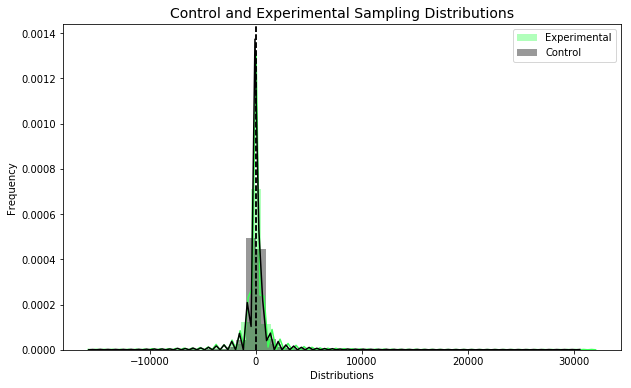

In [23]:
control = df[df['Discount']==0]['Revenue']

experimental = df[df['Discount']> 0]['Revenue']

if stats.kstest(experimental, 'norm', args=(experimental.mean(),experimental.std()))[1] > .05:
    p = stats.ttest_ind(control, experimental)[1]
    d = round(Cohen_d(control, experimental),4)
    dt = 1
    print('Welch T test used')
else:
    p = stats.mannwhitneyu(control, experimental)[1]
    d = round(Cohen_dmed(control, experimental),4)
    dt = 0
    print('Mann Whitney U test used')



print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d) if d ==1 else print("Cohen's d w/ median:", d)
print('Average Made on Wtihout Discount: ' + str(round(df[df['Discount']==0]['Revenue'].mean(),2)))
print('Average Made on With Discount: ' + str(round(df[df['Discount']>0]['Revenue'].mean(),2)))
visualization(control, experimental,['#3DFF57','#000000'])


### Conclusion
The results show that there is a statistically significant difference between orders made with and without discounts.
NorthWind made more money on Average from orders with discounts than orders without discounts.  Hence we reject the null.

# Question 2(B): What items make more off Discounts?

*$H_{0}$* : There is no significant difference in amount made due to discounts per item<br>
*$H_{a}$* : There is a significant difference in amount made due to discounts per item

In [33]:
categorylist = ['Beverages','Condiments','Sweets','Dairy','Grain Products','Meat','Produce','SeaFood']
for x in sorted(df['CategoryId'].unique()):

    control = df[(df['Discount']==0) & (df['CategoryId']==x) ]['Revenue']

    experimental = df[(df['Discount']> 0) & (df['CategoryId']==x)]['Revenue']
    
    #Normality test
    if stats.kstest(experimental, 'norm', args=(experimental.mean(),experimental.std()))[1] > .05:
        p = stats.ttest_ind(control, experimental)[1]
        d = round(Cohen_d(control, experimental),4)
        dt = 1
        print('Welch T test used')
    else:
        p = stats.mannwhitneyu(control, experimental)[1]
        d = round(Cohen_dmed(control, experimental),4)
        dt = 0
        print('Mann Whitney U test used')

    print(categorylist[x-1])
    print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
    print("Cohen's d:", d) if d ==1 else print("Cohen's d w/ median:", d)
    print('Average Made on Wtihout Discount: ' + str(round(df[(df['Discount']==0) & (df['CategoryId']==x) ]['Revenue'].mean(),2)))
    print('Average Made on With Discount: ' + str(round(df[(df['Discount']> 0) & (df['CategoryId']==x)]['Revenue'].mean(),2)))
    print('------------------------------------')

Mann Whitney U test used
Beverages
Failed to reject Null Hypothesis
Cohen's d w/ median: 0.0003
Average Made on Wtihout Discount: 253.09
Average Made on With Discount: 315.83
------------------------------------
Mann Whitney U test used
Condiments
Reject Null Hypothesis
Cohen's d w/ median: 0.011
Average Made on Wtihout Discount: -73.6
Average Made on With Discount: -88.68
------------------------------------
Mann Whitney U test used
Sweets
Failed to reject Null Hypothesis
Cohen's d w/ median: 0.001
Average Made on Wtihout Discount: -27.66
Average Made on With Discount: -31.8
------------------------------------
Mann Whitney U test used
Dairy
Reject Null Hypothesis
Cohen's d w/ median: 0.0316
Average Made on Wtihout Discount: 50.53
Average Made on With Discount: 65.01
------------------------------------
Mann Whitney U test used
Grain Products
Failed to reject Null Hypothesis
Cohen's d w/ median: 0.0007
Average Made on Wtihout Discount: -135.19
Average Made on With Discount: -164.94
--

### Conclusion
For Beverages, Meat, and Seafood there is a statistically significant difference between amount made with/without Discounts.  For those items we can reject the null.

## Question3(A): Do different Months have a statistically significant impact on money made per item?
##### Do buying habits change per month?

*$H_{0}$* : There is no significant difference on average money made per items in the different months <br>
*$H_{a}$* : There is a significant difference on average money made per items in the different months

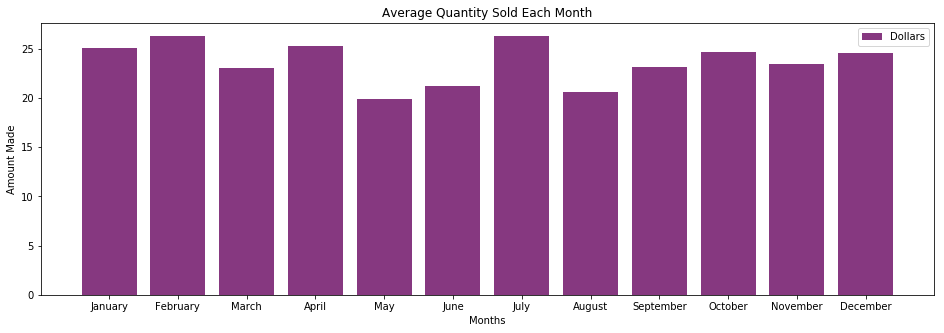

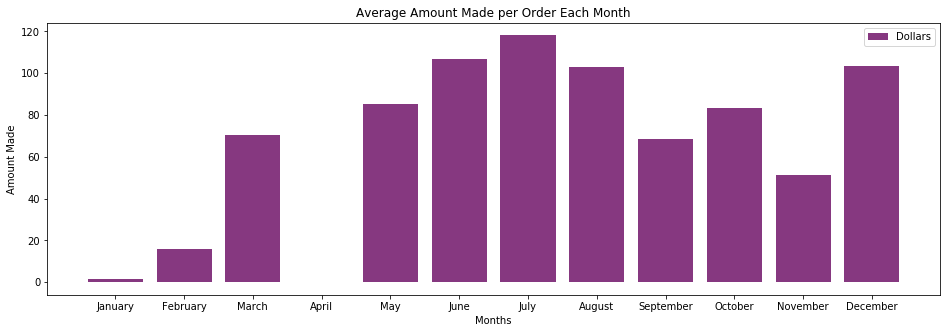

In [13]:
Amountsoldpermonth = df.groupby('Month')['Quantity'].mean().reindex(index =['January','February','March','April','May','June','July','August','September','October','November','December'] )
Amountmadepermonth = df.groupby('Month')['Revenue'].mean().reindex(index =['January','February','March','April','May','June','July','August','September','October','November','December'] )
plt.figure(figsize=(16,5))

plt.bar(Amountsoldpermonth.index, Amountsoldpermonth.values, alpha=1, label='Dollars', color='#863880')
plt.legend()
plt.title('Average Quantity Sold Each Month')
plt.xlabel('Months')
plt.ylabel('Amount Made')
plt.show()

plt.figure(figsize=(16,5))
plt.bar(Amountmadepermonth.index, Amountmadepermonth.values, alpha=1, label='Dollars', color='#863880')
plt.legend()
plt.title('Average Amount Made per Order Each Month')
plt.xlabel('Months')
plt.ylabel('Amount Made')
plt.show()

In [15]:
dfcm=pd.DataFrame()
dfcm['Total']=df.groupby('CategoryId')['Revenue'].mean()
for x in list(df['Month'].unique()):
    dfcm[str(x)] = df.loc[df['Month']==x].groupby('CategoryId')['Revenue'].mean()
dfcm  = dfcm[['Total','January','February','March','April','May','June','July','August','September','October','November','December']]
dfcm

,Total,January,February,March,April,May,June,July,August,September,October,November,December
CategoryId,,,,,,,,,,,,,
1,277.426964,230.100168,255.555855,280.937843,230.774485,266.978759,300.515982,357.745232,290.565511,279.155207,308.799621,264.875183,327.909100
2,-79.446031,-143.732434,-137.066513,-63.373200,-147.152799,-30.441310,-16.616438,-34.462162,-16.518933,-65.620798,-60.048864,-85.069817,-39.532832
3,-29.264504,-91.166140,-81.858105,-14.958066,-94.010734,11.380272,27.976986,20.687895,26.661600,-17.140284,-8.183409,-35.862467,12.134840
4,56.145770,-1.696930,12.108053,67.445761,-3.561544,82.561701,103.876164,114.554737,100.156000,65.374823,80.092955,47.889733,100.074574
5,-146.733537,-214.217632,-211.094474,-128.292181,-218.410039,-86.519116,-76.410959,-108.411880,-74.418933,-130.627447,-129.594318,-151.051067,-108.813085
6,660.876031,631.771813,677.416526,650.889479,636.845740,586.547483,641.265023,779.160025,620.518311,649.606430,705.115985,640.880333,722.714167
7,143.230756,89.526579,107.916684,151.465350,88.661158,155.138844,181.263562,210.262105,175.091467,149.507872,170.100227,133.284133,189.738617
8,-136.386214,-203.378575,-199.710618,-118.309084,-207.452259,-77.895595,-67.215890,-97.040056,-65.515200,-120.630869,-118.899773,-140.904617,-98.159322


In [16]:
formula = 'Total ~  January + February + March + April + May + June + July + August + September + October + November + December'
lm = ols(formula, dfcm).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
January,7.972942e+03,1.0,3.177792e+28,2.103426e-84
February,1.118651e+04,1.0,4.458630e+28,7.615518e-85
March,3.678631e+05,1.0,1.466200e+30,2.141532e-89
April,7.653750e+03,1.0,3.050571e+28,2.377718e-84
May,1.520668e+04,1.0,6.060957e+28,3.031657e-85
June,5.701670e+03,1.0,2.272527e+28,5.751442e-84
July,1.104800e+04,1.0,4.403425e+28,7.905546e-85
August,5.837610e+03,1.0,2.326709e+28,5.358927e-84
September,5.026015e+05,1.0,2.003229e+30,8.396759e-90
October,1.127230e+05,1.0,4.492824e+29,7.442957e-88


### Conclusion
There is no statistically significant difference between how much money per item each month.  The buying habits of the customers stay relativly the same every month.  We failed to reject the null.

## Question3(B): Do different Months have a statistically significant impact on money made per order?

*$H_{0}$* : There is no significant difference on average money made per order in the different months <br>
*$H_{a}$* : There is a significant difference on average money made per order in the different months

Let's analyze the outliars of this data, April and July

Mann Whitney U test used
Month: April
Reject Null Hypothesis
Cohen's d w/ median: 0.0124
-------------


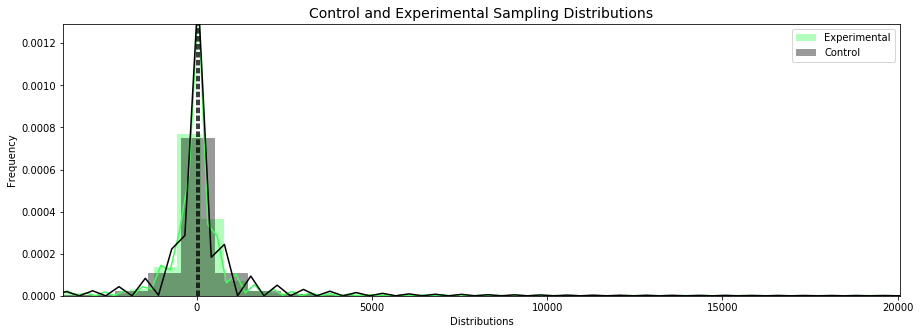

Mann Whitney U test used
Month: July
Reject Null Hypothesis
Cohen's d w/ median: 0.0051
-------------


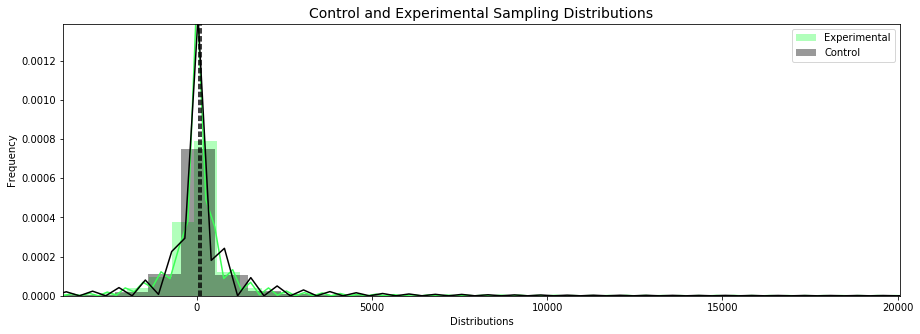

In [34]:
Monthlist = ['April', 'July']
for x in Monthlist:
    control = df[df['Month']!=str(x)]['Revenue']

    experimental = df[df['Month']==str(x)]['Revenue']
    if stats.kstest(experimental, 'norm', args=(experimental.mean(),experimental.std()))[1] > .05:
        p = stats.ttest_ind(control, experimental)[1]
        d = round(Cohen_d(control, experimental),4)
        dt = 1
        print('Welch T test used')
    else:
        p = stats.mannwhitneyu(control, experimental)[1]
        d = round(Cohen_dmed(control, experimental),4)
        dt = 0
        print('Mann Whitney U test used')

    print('Month: '+str(x))
    print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
    print("Cohen's d:", d) if d ==1 else print("Cohen's d w/ median:", d)
    print('-------------')
    smallvisualization(control, experimental,['#3DFF57','#000000'])

### Conclusion
There is a statistically significant difference between the money made per order each month with April being the lowest selling month and July being the highest selling month.  We reject the null for those months.

## Question4(A): Do different Regions have a statistically significant impact on money made per item?
##### Do buying habits change per region?

*$H_{0}$* : There is no significant difference on average money made per order in the different Regions <br>
*$H_{a}$* : There is a significant difference on average money made per order in the different Regions

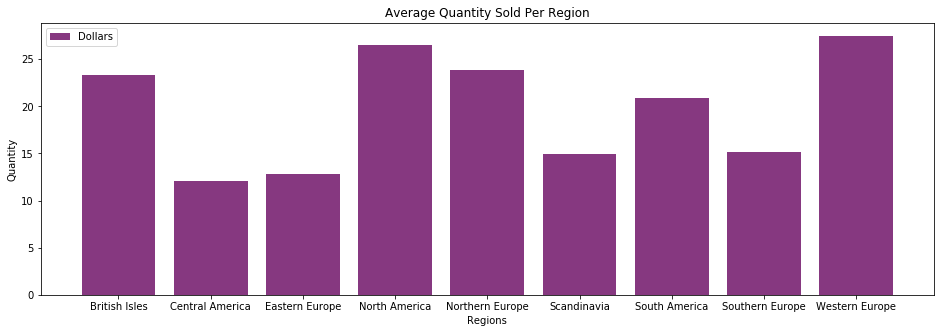

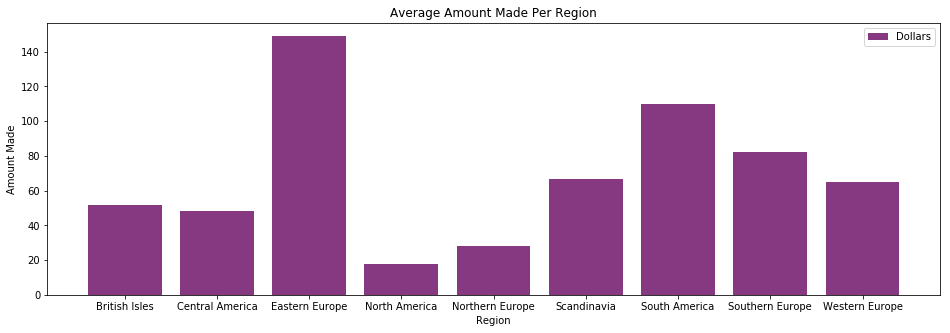

In [18]:
AmountsoldperRegion = df.groupby('ShipRegion')['Quantity'].mean()
AmountmadeperRegion = df.groupby('ShipRegion')['Revenue'].mean()
plt.figure(figsize=(16,5))
plt.bar(AmountsoldperRegion.index, AmountsoldperRegion.values, alpha=1, label='Dollars', color='#863880')

plt.legend()
plt.title('Average Quantity Sold Per Region')
plt.xlabel('Regions')
plt.ylabel('Quantity')
plt.show()

plt.figure(figsize=(16,5))
plt.bar(AmountmadeperRegion.index, AmountmadeperRegion.values, alpha=1, label='Dollars', color='#863880')
plt.legend()
plt.title('Average Amount Made Per Region')
plt.xlabel('Region')
plt.ylabel('Amount Made')
plt.show()

In [20]:
dfcr=pd.DataFrame()
dfcr['Total']=df.groupby('CategoryId')['Revenue'].mean()
for x in list(df['ShipRegion'].unique()):
    dfcr[x] = df.loc[df['ShipRegion']==x].groupby('CategoryId')['Revenue'].mean()
    
    

dfcr = dfcr.rename(index=str, columns={"Western Europe":"WE","South America":"SA", "Central America":"CA"})
dfcr = dfcr.rename(index=str, columns = {"North America":"NA","Northern Europe":"NE","Scandinavia":"S"})
dfcr = dfcr.rename(index=str, columns = {"Southern Europe":"SE","British Isles":"BI","Eastern Europe":"EE"})
dfcr

,Total,WE,SA,CA,NA,NE,S,SE,BI,EE
CategoryId,,,,,,,,,,
1,277.426964,315.084415,300.307075,158.836818,259.473564,244.846941,203.037262,219.891405,264.009956,265.861198
2,-79.446031,-94.738842,-11.716225,-21.790455,-135.765703,-110.336626,-19.860357,-5.818449,-83.469868,74.741406
3,-29.264504,-37.111739,32.158783,3.608364,-80.189321,-60.392657,11.482286,25.919635,-34.609158,101.615625
4,56.145770,60.971101,106.835197,46.837818,14.403138,24.613287,64.828286,79.938686,48.553053,147.356250
5,-146.733537,-172.009986,-70.547434,-55.847273,-210.287073,-177.305594,-61.887143,-48.375474,-148.986316,38.706250
6,660.876031,755.426911,635.566524,352.915273,684.146011,626.480769,442.533905,462.409708,637.366351,471.213542
7,143.230756,160.977133,182.975855,90.914909,110.850351,111.286014,119.220286,135.016934,133.345895,193.993750
8,-136.386214,-160.127401,-61.500502,-50.610091,-198.827342,-167.007255,-55.424357,-41.831150,-138.911342,44.247656


In [21]:
formula = 'Total ~ WE + SA + CA + NA + NE + S + SE + BI + EE'
lm = ols(formula, dfcr).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

,sum_sq,df,F,PR(>F)
WE,1.765863e+05,1.0,6.835747e+29,2.113226e-88
SA,2.093623e+04,1.0,8.104522e+28,1.268007e-85
CA,1.268306e+05,1.0,4.909676e+29,5.703550e-88
NA,3.107496e+04,1.0,1.202928e+29,3.877799e-86
NE,4.422304e+04,1.0,1.711897e+29,1.345461e-86
S,5.635088e+04,1.0,2.181371e+29,6.503017e-87
SE,1.734061e+04,1.0,6.712640e+28,2.231638e-85
BI,1.423549e+05,1.0,5.510630e+29,4.033666e-88
EE,1.934256e+02,1.0,7.487605e+26,1.607959e-79
Residual,1.549967e-24,6.0,NaN,NaN


### Conclusion
There isnt a statistically significant difference between the buying habits in the different regions.  We failed to rejct the null.

## Question4(B): Do different Regions have a statistically significant impact on money made per order?

*$H_{0}$* : There is no significant difference on average money made per order in the different Regions <br>
*$H_{a}$* : There is a significant difference on average money made per order in the different Regions

Of course some regions will be closer to the average than others - so from the bar graph above, let's analyze the outliars.

Mann Whitney U test used
Region: Eastern Europe
Reject Null Hypothesis
Cohen's d w/ median: 0.0121
-------------


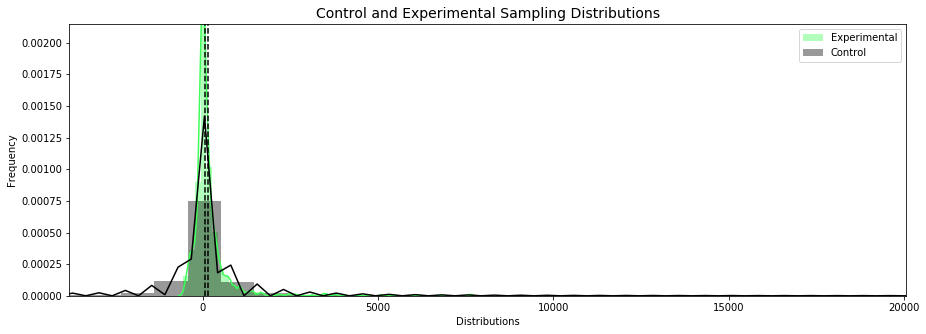

Mann Whitney U test used
Region: North America
Reject Null Hypothesis
Cohen's d w/ median: 0.0128
-------------


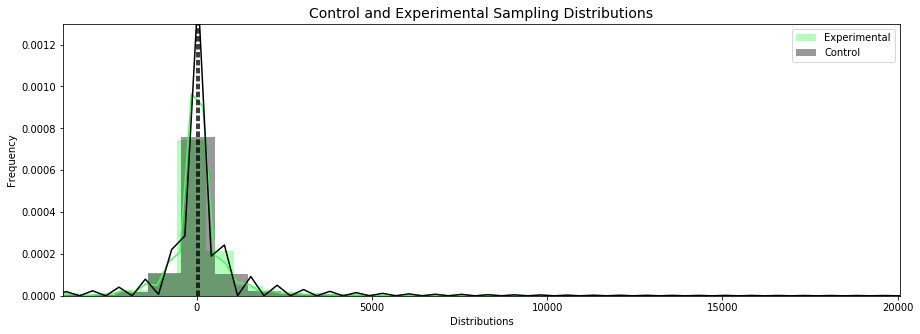

In [35]:
Regionlist = ['Eastern Europe', 'North America']
for x in Regionlist:
    control = df[df['ShipRegion']!=str(x)]['Revenue']

    experimental = df[df['ShipRegion']==str(x)]['Revenue']

    if stats.kstest(experimental, 'norm', args=(experimental.mean(),experimental.std()))[1] > .05:
        p = stats.ttest_ind(control, experimental)[1]
        d = round(Cohen_d(control, experimental),4)
        dt = 1
        print('Welch T test used')
    else:
        p = stats.mannwhitneyu(control, experimental)[1]
        d = round(Cohen_dmed(control, experimental),4)
        dt = 0
        print('Mann Whitney U test used')

    print('Region: '+str(x))
    print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
    print("Cohen's d:", d) if d ==1 else print("Cohen's d w/ median:", d)
    print('-------------')
    smallvisualization(control, experimental,['#3DFF57','#000000'])

### Conclusion
There is a statistically significant difference on the money made per order in different regions.  With Eastern Europe having the highest profit margins and North America having the lowest profit margins.  In those regions we can reject the null.

## Further Research:
Maybe it's worth losing money on some items if it brings in customers that buy more of other things.  I wanted to look at the customers who bought a higher percentage of loss leaders and analyze the different customer demographics.

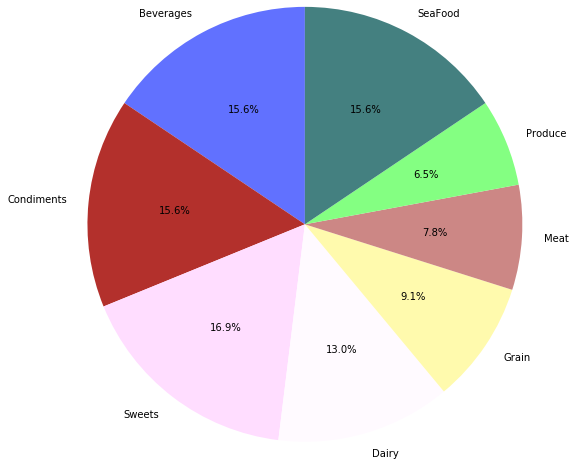

In [23]:
labels = ['Beverages','Condiments','Sweets','Dairy','Grain','Meat','Produce','SeaFood']
Amountsold = df.groupby('CategoryId')['Quantity'].sum()
colors = ['#6171FF', '#B3302C', '#FFDDFF', '#FFFAFF', '#FFFAAD', '#CC8785','#84FF82','#448080']
plt.pie(Amountsold, labels=labels,colors=colors, autopct='%1.1f%%',startangle=90,radius=2.5);

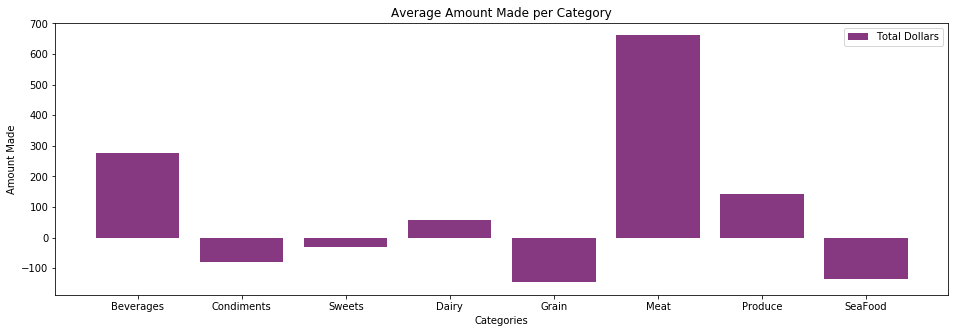

In [24]:
Revpercat = df.groupby('CategoryId')['Revenue'].mean()
plt.figure(figsize=(16,5))
plt.bar(['Beverages','Condiments','Sweets','Dairy','Grain','Meat','Produce','SeaFood'], Revpercat.values, alpha=1, label='Total Dollars', color='#863880')

plt.legend()
plt.title('Average Amount Made per Category')
plt.xlabel('Categories')
plt.ylabel('Amount Made')
plt.show()

In [25]:
#Customer Dataframe = cdf
cdf = pd.DataFrame(columns = ['Id','1','2','3','4','5','6','7','8'])
for x,j in list(zip(df['Id'].unique(),range(len(df['Id'].unique())))):
#amount bought = AB
    AB = df.loc[df['Id']==x].groupby('CategoryId')['Quantity'].sum()
    perc = []
    total = sum(AB)
    perc.append(x)
    for i in AB:
        perc.append(i/total)
    cdf.loc[j] = perc
cdf.head()

,Id,1,2,3,4,5,6,7,8
0,VINET,0.155844,0.155844,0.168831,0.12987,0.090909,0.077922,0.064935,0.155844
1,TOMSP,0.155844,0.155844,0.168831,0.12987,0.090909,0.077922,0.064935,0.155844
2,HANAR,0.155844,0.155844,0.168831,0.12987,0.090909,0.077922,0.064935,0.155844
3,VICTE,0.155844,0.155844,0.168831,0.12987,0.090909,0.077922,0.064935,0.155844
4,SUPRD,0.155844,0.155844,0.168831,0.12987,0.090909,0.077922,0.064935,0.155844


## oops!  Too bad this does not work for this company because every customer ordred the same percentage of every item

In [26]:
#helper function to remove rows with certain CategoryId
def removerows(df, idList):
    for i in idList:
        df = df[df.Id != i]
    return df

Failed to reject Null Hypothesis
Cohen's d: nan
n1 = 85  n2 = 0


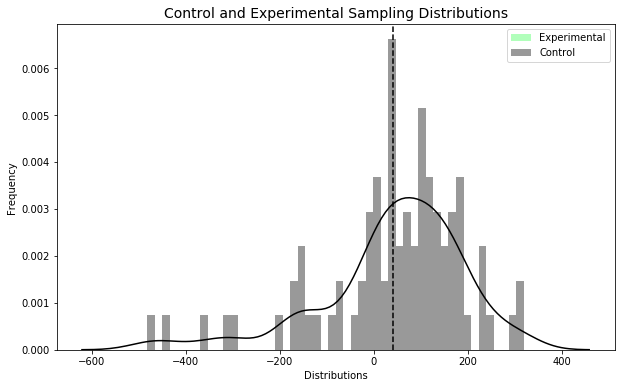

In [27]:
# for seafood aka number 8
#threshold is over 18.6
threshold = 18.6
thresholdId = []
for i in cdf.iterrows():
    if i[1][8] > threshold/100:
        thresholdId.append(i[1][0])
newdf = removerows(df,thresholdId)
control = newdf.groupby('Id')['Revenue'].mean()
experimental = df.loc[df['Id'].isin(thresholdId)].groupby('Id')['Revenue'].mean()

t_stat, p = stats.ttest_ind(control, experimental)
d = Cohen_d(experimental, control)

print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')
print("Cohen's d:", d)
print('n1 = ' + str(len(newdf.Id.unique())) +'  n2 = '+ str(len(thresholdId)))
visualization(control, experimental,['#3DFF57','#000000'])

# Conclusion: <br>
It is worth giving discounts, it sells more items and brings in more profit - however - If you look at seafood, it rejected the null for the wrong reason.  It was losing more money than the average sale without discounts. <br>
If you look at the months, it would be wise not place as many orders for food on unprofitable months.  You don't want to be left with overstock and being forced to give discounts just to cut losses. <br>
If you look at the Regions, North America didnt have many profitable sales considering how much they ordered vs how much they profitted on average.
It would be wise to not give as many discounts on your loss leaders - or order as many as you need when profitable months come so youre not forced to give discounts.



## Thank you!
A special thanks to my team mate Gabe and my instructor Brandon for bounching ideas off of.
And thanks to Flatiron for helping me not only comprehend but apply these statistical concepts in a real world scenario. <br>
#### Resources <br>
https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-20-hypothesis-and-ab-testing/effect-sizes <br>

https://learn.co/tracks/data-science-career-v1-1/module-2-advanced-data-retrieval-and-analysis/section-20-hypothesis-and-ab-testing/anova

